In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
mode = 'valence-arousal'
seed = 0

In [8]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import random_split


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


訓練データの分布をカーネル密度推定により平滑化し，MSEに重みづけする

In [9]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from scipy.stats import gaussian_kde

class KDEWeightLoss(_Loss):
    def __init__(self, dataset, mode, bw_method=None, eps=1e-6, device=None):
        super(KDEWeightLoss, self).__init__()
        assert mode in ('valence', 'arousal', 'valence-arousal')
        self.mode = mode
        self.bw_method = bw_method
        self.eps = eps
        self.device = device
        self.kernel = self._calc_kernel(dataset.df)
    
    def forward(self, pred, target):
        loss = torch.mean(torch.dot(torch.tensor(1 / (self.kernel(target.cpu().T) + self.eps)).float().to(self.device),
                                    ((pred - target) ** 2).sum(1)))
        return loss
    
    def _calc_kernel(self, df):
        if self.mode == 'arousal':
            data = df[self.mode].to_numpy().T
        elif self.mode == 'valence':
            data = df[self.mode].to_numpy().T
        else:
            data = df[['valence', 'arousal']].to_numpy().T
        return gaussian_kde(data, bw_method=self.bw_method)

In [10]:
from transformers import Trainer
import wandb

class KDEWeightLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = KDEWeightLoss(dataset=train_dataset,
                                      mode=mode,
                                      bw_method=0.2,
                                      device=self.args.device).to(self.args.device)
        self.mse = nn.MSELoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        mse = self.mse(logits, labels)
        rmse = torch.sqrt(mse)
        wandb.log({'train/mse': mse, 'train/rmse': rmse})
        return (loss, outputs) if return_outputs else loss

In [11]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=2,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='KDE-valaro', id='kde_valaro_230403')

args = TrainingArguments(
    f"affectnet-kde-aroval",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    mse = mean_squared_error(targets, preds, squared=True) / 2
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [14]:
from transformers import EarlyStoppingCallback

trainer = KDEWeightLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [15]:
trainer.train()

c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 500/300720 [11:27<92:01:29,  1.10s/it] 

{'loss': 46.1314, 'learning_rate': 9.98337323756318e-07, 'epoch': 0.05}


  0%|          | 1000/300720 [29:00<177:06:27,  2.13s/it]

{'loss': 41.0941, 'learning_rate': 9.966746475126364e-07, 'epoch': 0.1}


  0%|          | 1500/300720 [47:15<180:46:25,  2.17s/it]

{'loss': 39.2135, 'learning_rate': 9.950119712689545e-07, 'epoch': 0.15}


  1%|          | 2000/300720 [56:52<91:46:04,  1.11s/it] 

{'loss': 37.5511, 'learning_rate': 9.933492950252726e-07, 'epoch': 0.2}


  1%|          | 2500/300720 [1:06:08<89:57:32,  1.09s/it]

{'loss': 34.8457, 'learning_rate': 9.916866187815907e-07, 'epoch': 0.25}


  1%|          | 3000/300720 [1:15:23<92:33:03,  1.12s/it]

{'loss': 35.4683, 'learning_rate': 9.90023942537909e-07, 'epoch': 0.3}


  1%|          | 3500/300720 [1:24:40<92:38:30,  1.12s/it] 

{'loss': 31.2039, 'learning_rate': 9.88361266294227e-07, 'epoch': 0.35}


  1%|▏         | 4000/300720 [1:33:55<90:12:49,  1.09s/it]

{'loss': 32.189, 'learning_rate': 9.866985900505454e-07, 'epoch': 0.4}


  1%|▏         | 4500/300720 [1:43:10<89:58:40,  1.09s/it]

{'loss': 31.6273, 'learning_rate': 9.850359138068635e-07, 'epoch': 0.45}


  2%|▏         | 5000/300720 [1:52:23<89:53:11,  1.09s/it]

{'loss': 30.2562, 'learning_rate': 9.833732375631816e-07, 'epoch': 0.5}


  2%|▏         | 5500/300720 [2:01:35<89:15:39,  1.09s/it]

{'loss': 30.3061, 'learning_rate': 9.817105613194997e-07, 'epoch': 0.55}


  2%|▏         | 6000/300720 [2:10:48<87:54:39,  1.07s/it]

{'loss': 28.2845, 'learning_rate': 9.80047885075818e-07, 'epoch': 0.6}


  2%|▏         | 6500/300720 [2:20:01<88:53:39,  1.09s/it]

{'loss': 29.9026, 'learning_rate': 9.783852088321361e-07, 'epoch': 0.65}


  2%|▏         | 7000/300720 [2:29:13<90:27:37,  1.11s/it]

{'loss': 28.6239, 'learning_rate': 9.767225325884544e-07, 'epoch': 0.7}


  2%|▏         | 7500/300720 [2:38:26<89:54:22,  1.10s/it]

{'loss': 30.4439, 'learning_rate': 9.750598563447725e-07, 'epoch': 0.75}


  3%|▎         | 8000/300720 [2:47:42<92:52:54,  1.14s/it]

{'loss': 27.2443, 'learning_rate': 9.733971801010906e-07, 'epoch': 0.8}


  3%|▎         | 8500/300720 [2:56:57<87:21:29,  1.08s/it]

{'loss': 28.0579, 'learning_rate': 9.71734503857409e-07, 'epoch': 0.85}


  3%|▎         | 9000/300720 [3:06:38<89:12:32,  1.10s/it] 

{'loss': 27.2036, 'learning_rate': 9.70071827613727e-07, 'epoch': 0.9}


  3%|▎         | 9500/300720 [3:16:02<90:59:24,  1.12s/it] 

{'loss': 28.9381, 'learning_rate': 9.684091513700452e-07, 'epoch': 0.95}


  3%|▎         | 10000/300720 [3:25:16<89:45:47,  1.11s/it]

{'loss': 27.1304, 'learning_rate': 9.667464751263633e-07, 'epoch': 1.0}


                                                           
  3%|▎         | 10024/300720 [3:27:26<67:50:37,  1.19it/s]

{'eval_loss': 27.05851936340332, 'eval_mse': 0.09002509713172913, 'eval_rmse': 0.30004182563724197, 'eval_runtime': 104.6202, 'eval_samples_per_second': 43.013, 'eval_steps_per_second': 2.695, 'epoch': 1.0}


  3%|▎         | 10500/300720 [3:38:52<85:25:40,  1.06s/it]  

{'loss': 28.9197, 'learning_rate': 9.650837988826816e-07, 'epoch': 1.05}


  4%|▎         | 11000/300720 [3:49:32<87:57:24,  1.09s/it] 

{'loss': 26.8387, 'learning_rate': 9.634211226389997e-07, 'epoch': 1.1}


  4%|▍         | 11500/300720 [3:58:48<85:40:24,  1.07s/it]

{'loss': 27.8647, 'learning_rate': 9.61758446395318e-07, 'epoch': 1.15}


  4%|▍         | 12000/300720 [4:11:30<163:25:13,  2.04s/it]

{'loss': 25.9694, 'learning_rate': 9.60095770151636e-07, 'epoch': 1.2}


  4%|▍         | 12500/300720 [4:22:26<90:35:57,  1.13s/it] 

{'loss': 26.6427, 'learning_rate': 9.584330939079542e-07, 'epoch': 1.25}


  4%|▍         | 13000/300720 [4:31:56<93:37:42,  1.17s/it]

{'loss': 26.5377, 'learning_rate': 9.567704176642723e-07, 'epoch': 1.3}


  4%|▍         | 13500/300720 [4:41:13<86:23:30,  1.08s/it]

{'loss': 27.0756, 'learning_rate': 9.551077414205906e-07, 'epoch': 1.35}


  5%|▍         | 14000/300720 [4:54:46<87:57:22,  1.10s/it] 

{'loss': 25.4077, 'learning_rate': 9.534450651769087e-07, 'epoch': 1.4}


  5%|▍         | 14500/300720 [5:07:37<169:13:04,  2.13s/it]

{'loss': 25.4639, 'learning_rate': 9.517823889332269e-07, 'epoch': 1.45}


  5%|▍         | 15000/300720 [5:24:50<170:36:41,  2.15s/it]

{'loss': 27.1196, 'learning_rate': 9.50119712689545e-07, 'epoch': 1.5}


  5%|▌         | 15500/300720 [5:38:17<86:24:37,  1.09s/it] 

{'loss': 26.6827, 'learning_rate': 9.484570364458632e-07, 'epoch': 1.55}


  5%|▌         | 16000/300720 [5:50:52<169:29:33,  2.14s/it]

{'loss': 25.8889, 'learning_rate': 9.467943602021814e-07, 'epoch': 1.6}


  5%|▌         | 16500/300720 [6:06:57<85:04:45,  1.08s/it] 

{'loss': 27.3139, 'learning_rate': 9.451316839584995e-07, 'epoch': 1.65}


  6%|▌         | 17000/300720 [6:16:04<85:01:13,  1.08s/it]

{'loss': 24.9301, 'learning_rate': 9.434690077148177e-07, 'epoch': 1.7}


  6%|▌         | 17500/300720 [6:25:10<84:14:30,  1.07s/it]

{'loss': 26.1929, 'learning_rate': 9.418063314711358e-07, 'epoch': 1.75}


  6%|▌         | 18000/300720 [6:34:18<86:24:23,  1.10s/it]

{'loss': 25.0769, 'learning_rate': 9.40143655227454e-07, 'epoch': 1.8}


  6%|▌         | 18500/300720 [6:43:24<86:01:13,  1.10s/it]

{'loss': 25.7791, 'learning_rate': 9.384809789837723e-07, 'epoch': 1.85}


  6%|▋         | 19000/300720 [6:52:28<86:32:53,  1.11s/it]

{'loss': 26.9722, 'learning_rate': 9.368183027400905e-07, 'epoch': 1.9}


  6%|▋         | 19500/300720 [7:01:36<85:31:05,  1.09s/it]

{'loss': 24.9005, 'learning_rate': 9.351556264964086e-07, 'epoch': 1.95}


  7%|▋         | 20000/300720 [7:10:43<83:13:55,  1.07s/it]

{'loss': 25.2219, 'learning_rate': 9.334929502527268e-07, 'epoch': 2.0}


                                                           
  7%|▋         | 20048/300720 [7:13:17<63:36:52,  1.23it/s]

{'eval_loss': 25.729740142822266, 'eval_mse': 0.0861642062664032, 'eval_rmse': 0.2935374018185812, 'eval_runtime': 102.5448, 'eval_samples_per_second': 43.883, 'eval_steps_per_second': 2.75, 'epoch': 2.0}


  7%|▋         | 20500/300720 [7:21:31<85:27:10,  1.10s/it]  

{'loss': 24.1548, 'learning_rate': 9.318302740090449e-07, 'epoch': 2.05}


  7%|▋         | 21000/300720 [7:39:06<165:32:36,  2.13s/it]

{'loss': 25.192, 'learning_rate': 9.301675977653632e-07, 'epoch': 2.09}


  7%|▋         | 21500/300720 [7:55:56<159:18:59,  2.05s/it]

{'loss': 25.3764, 'learning_rate': 9.285049215216813e-07, 'epoch': 2.14}


  7%|▋         | 22000/300720 [8:12:54<164:26:05,  2.12s/it]

{'loss': 24.9788, 'learning_rate': 9.268422452779995e-07, 'epoch': 2.19}


  7%|▋         | 22500/300720 [8:30:53<168:04:23,  2.17s/it]

{'loss': 25.0935, 'learning_rate': 9.251795690343176e-07, 'epoch': 2.24}


  8%|▊         | 23000/300720 [8:46:30<85:57:44,  1.11s/it] 

{'loss': 25.1072, 'learning_rate': 9.235168927906357e-07, 'epoch': 2.29}


  8%|▊         | 23500/300720 [8:55:52<87:19:56,  1.13s/it]

{'loss': 24.1468, 'learning_rate': 9.218542165469539e-07, 'epoch': 2.34}


  8%|▊         | 24000/300720 [9:05:18<92:38:19,  1.21s/it] 

{'loss': 24.0304, 'learning_rate': 9.201915403032721e-07, 'epoch': 2.39}


  8%|▊         | 24500/300720 [9:14:36<87:02:45,  1.13s/it]

{'loss': 23.9285, 'learning_rate': 9.185288640595903e-07, 'epoch': 2.44}


  8%|▊         | 25000/300720 [9:24:07<88:47:51,  1.16s/it]

{'loss': 26.5774, 'learning_rate': 9.168661878159084e-07, 'epoch': 2.49}


  8%|▊         | 25500/300720 [9:33:30<84:54:00,  1.11s/it]

{'loss': 23.666, 'learning_rate': 9.152035115722266e-07, 'epoch': 2.54}


  9%|▊         | 26000/300720 [9:42:51<89:29:07,  1.17s/it]

{'loss': 23.9278, 'learning_rate': 9.135408353285447e-07, 'epoch': 2.59}


  9%|▉         | 26500/300720 [9:52:51<85:53:13,  1.13s/it] 

{'loss': 25.3519, 'learning_rate': 9.118781590848629e-07, 'epoch': 2.64}


  9%|▉         | 27000/300720 [10:02:42<85:52:55,  1.13s/it]

{'loss': 24.2847, 'learning_rate': 9.102154828411811e-07, 'epoch': 2.69}


  9%|▉         | 27500/300720 [10:12:12<88:41:10,  1.17s/it]

{'loss': 23.9168, 'learning_rate': 9.085528065974994e-07, 'epoch': 2.74}


  9%|▉         | 28000/300720 [10:21:47<84:51:01,  1.12s/it]

{'loss': 25.9233, 'learning_rate': 9.068901303538175e-07, 'epoch': 2.79}


  9%|▉         | 28139/300720 [10:24:25<85:55:05,  1.13s/it]

KeyboardInterrupt: 

In [16]:
trainer.save_state()
trainer.save_model()
# wandb.finish()

In [17]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [18]:
from umap import UMAP
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

def plot_tokens(tokens, targets, n_neighbors):
    fig = plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for i, category in enumerate(['valence', 'arousal']):
        umap = UMAP(n_neighbors=n_neighbors)
        xy = np.array(umap.fit_transform(tokens.numpy()))
        x = xy[:, 0]
        y = xy[:, 1]
        z = targets[:, i]
        ax = fig.add_subplot(1, 2, i+1)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('feature-1')
        ax.set_ylabel('feature-2')
        ax.set_title(category)
        mp = ax.scatter(x, y,
                        alpha=1,
                        c=z,
                        cmap='Oranges',
                        vmin=-1,
                        vmax=1,
                        s=3)
        fig.colorbar(mp, ax=ax, shrink=0.335)
    plt.show()
    return fig


In [20]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
print(tokens.shape, targets.shape)

100%|██████████| 4500/4500 [01:56<00:00, 38.68it/s]

torch.Size([4500, 768]) torch.Size([4500, 2])


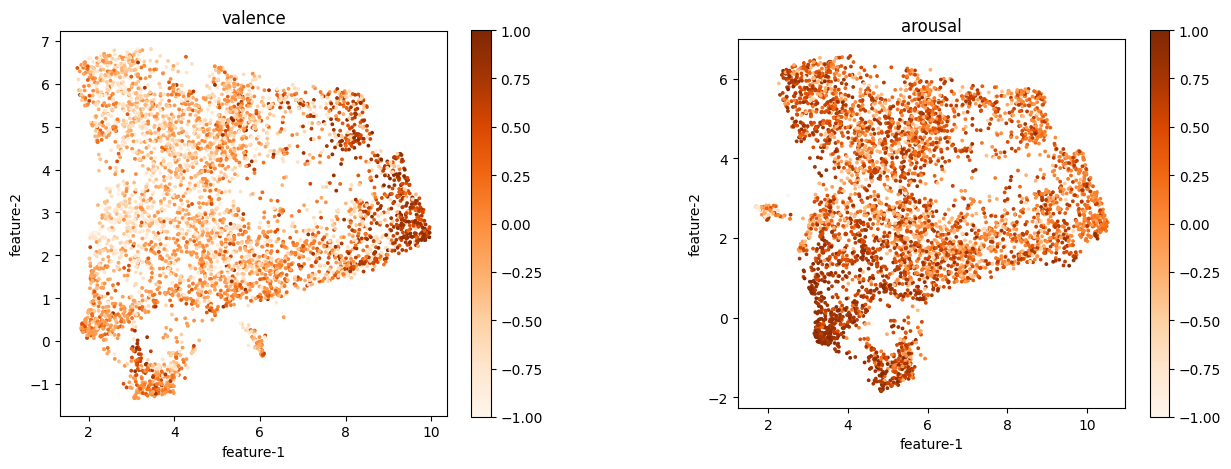

In [24]:
finetuned_fig = plot_tokens(tokens, targets, 30)

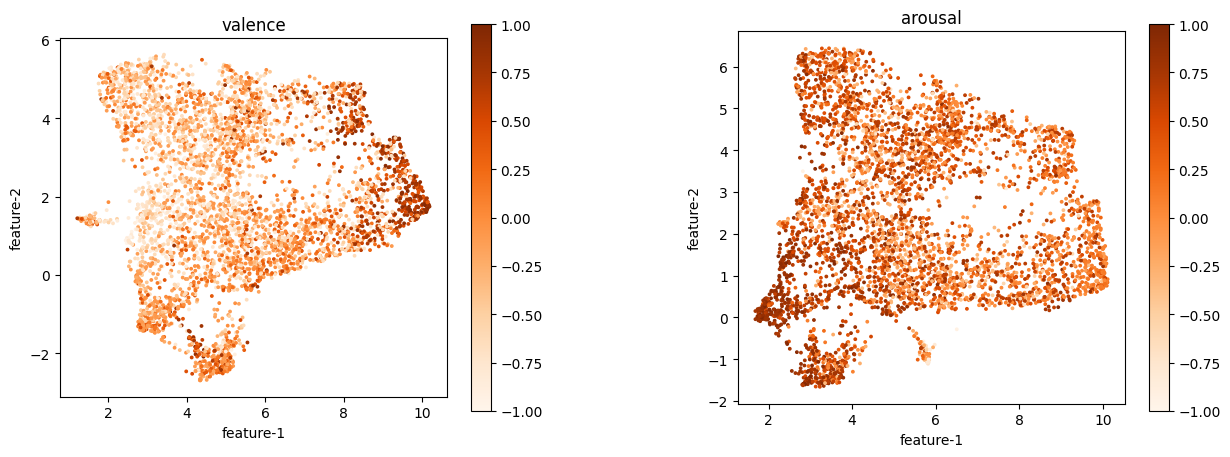

In [25]:
finetuned_fig = plot_tokens(tokens, targets, 30)
wandb.log({'finetuned-plot': wandb.Image(finetuned_fig)})

In [27]:
non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=2,
                                                                problem_type='regression')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 4500/4500 [02:06<00:00, 35.60it/s]


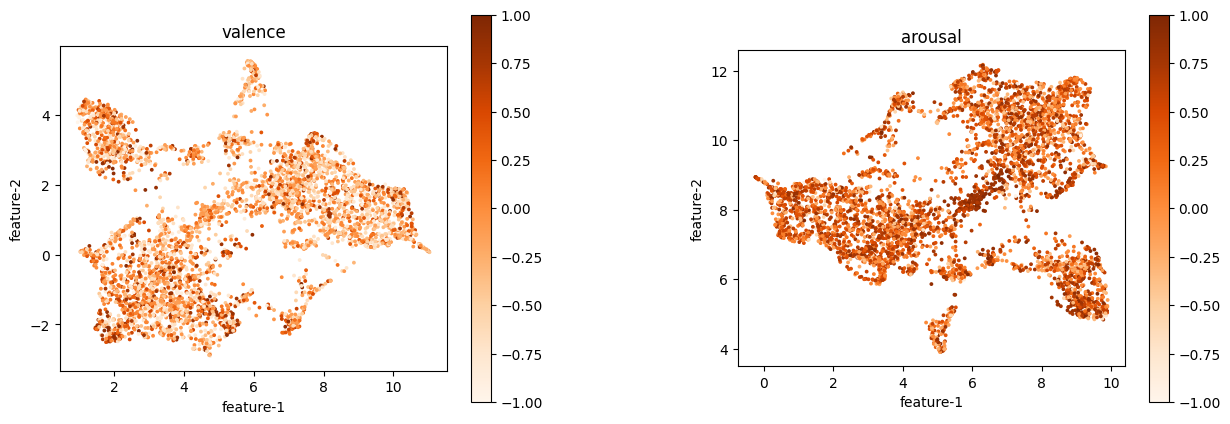

In [28]:
tokens, targets = CLE_tokens(non_finetuned_model.to(device),
                             feature_extractor,
                             val_dataset,
                             device)
non_finetuned_fig = plot_tokens(tokens, targets, 30)
wandb.log({'non-finetuned-plot': wandb.Image(non_finetuned_fig)})

In [29]:
wandb.finish()

eval/loss,█▁
eval/mse,█▁
eval/rmse,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▆▄▅▄▃▃▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▂▁▂▁▂
train/mse,▆▅▆▄▃▄▃▂▂▂▂▂▂▂█▂▂▂▄▃▁▁▂▃▁▂▄▃▅▂▁▃▃▂▄▂▃▂▂▂
